In [2]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd

import os

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import data

Data source: https://www.kaggle.com/datasets/team-ai/spam-text-message-classification

In [5]:
data = pd.read_csv('/content/drive/MyDrive/SPAM text message 20170820 - Data.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Exploratory Data Analysis (EDA)

### General description

Conclusion:
- There are 5572 rows in the dataset;
- There are 2 columns in the dataset, "Category" and "Message";
- There are 2 types of categories;
- There are repeated messages;
- The top category, that is, the most repeated one, is 'ham'


In [6]:
print(len(data))
data.describe()

5572


,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


### Number of null elements

Conclusion: It is possible to check that there is no null values in the dataset.

In [7]:
data.isnull().sum()

,0
Category,0
Message,0


### Classes analysis
Types of categories and number of rows for each type

Conclusion:
- There are 2 different classes: 'ham' and 'spam';
- There are 4825 messages in the 'ham' class and 747 messages in the 'spam' class.

In [8]:
print(data['Category'].unique())

['ham' 'spam']


Category
ham     4825
spam     747
Name: count, dtype: int64


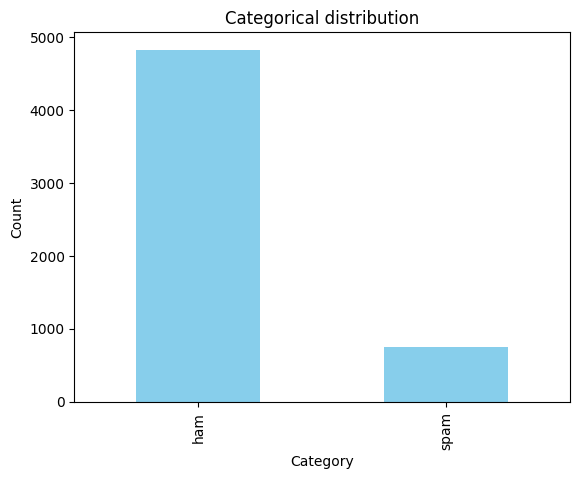

In [9]:
category_counts = data['Category'].value_counts()

category_counts.plot(kind='bar', color='skyblue')

plt.title('Categorical distribution')
plt.xlabel('Category')
plt.ylabel('Count')

print(category_counts)
plt.show()

### Messages analysis

Conclusion:
- The shortest message has 2 characters, and the longest one has 910 characters;
- Both shortest and longest messages were printed bellow.

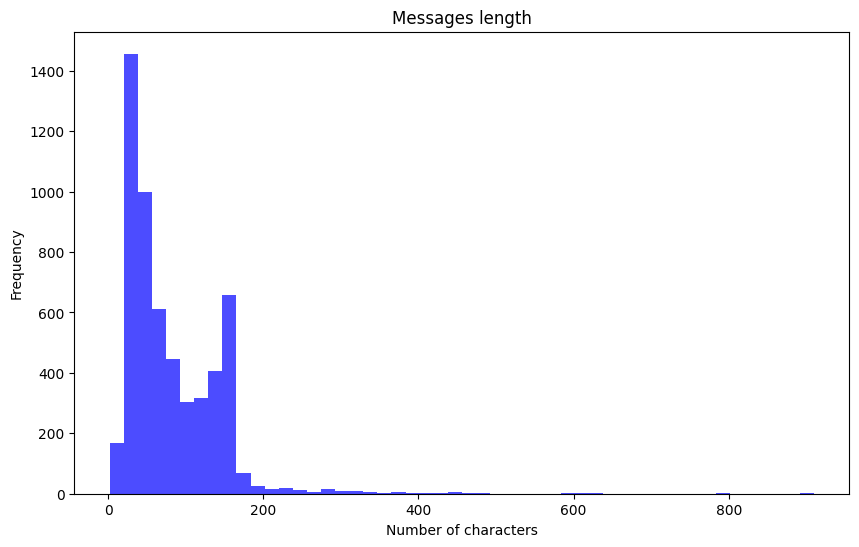

In [10]:
data['message_length'] = data['Message'].apply(len)

plt.figure(figsize=(10,6))
data['message_length'].plot(kind='hist', bins=50, alpha=0.7, color='blue')
plt.title('Messages length')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.show()

In [11]:
min_length = data['message_length'].min()
max_length = data['message_length'].max()

print('Shortest message length: ', str(min_length))
print('Longest message length: ', str(max_length))

shortest_message = data.loc[data['message_length'] == min_length, 'Message'].values[0]
longest_message = data.loc[data['message_length'] == max_length, 'Message'].values[0]

print('Shortest message: ', shortest_message)
print('Longest message: ', longest_message)

Shortest message length:  2
Longest message length:  910
Shortest message:  Ok
Longest message:  For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell 

# Apply preprocessing

The pipeline consists of:
1. **Tokenization**: Breaking down the text into individual words (tokens) to achieve a better and faster processing of the text.
2. **Lemmatization**: Reducing words to their base form (e.g., "running" becomes "run"), which helps in standardizing the text and improving model performance. Before lemmatization, the words in the message filtered through two steps:
  - **Stopwords**: Eliminate common words such as "and", "is", "the", etc., that do not carry much meaning in the message.
  - **Punctuation**: Exclude punctuation marks (such as periods, commas, question marks, etc.) to ensure that the text is free of unnecessary symbols, which they could interfere in the text processing.

By the end of the pipeline, the dataframe will have a new column 'processed_message' that consists of the return of the method 'preprocess_pipeline' applied to the row message.

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess_pipeline(message):
    tokens = word_tokenize(message.lower())
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]

    return processed_tokens

In [14]:
data['processed_message'] = data['Message'].apply(preprocess_pipeline)

In [15]:
data.head(10)

,Category,Message,message_length,processed_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,49,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,"[nah, think, go, usf, life, around, though]"
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147,"[freemsg, hey, darling, week, word, back, like..."
6,ham,Even my brother is not like to speak with me. ...,77,"[even, brother, like, speak, treat, like, aid,..."
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160,"[per, request, melle, oru, minnaminunginte, nu..."
8,spam,WINNER!! As a valued network customer you have...,157,"[winner, valued, network, customer, selected, ..."
9,spam,Had your mobile 11 months or more? U R entitle...,154,"[mobile, month, u, r, entitled, update, latest..."


# LSTM & Glove vectorization

## Glove

In [16]:
# embeddings_index = {}
# with open('glove.6B.100d.txt', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs

In [17]:
# def text_to_vector(text):
#     vector = np.zeros((100,))
#     for word in text:
#         if word in embeddings_index:
#             vector += embeddings_index[word]
#     return vector

# data['text_vector'] = data['cleaned_text'].apply(text_to_vector)
# print(data.head())

## LSTM

In [18]:
# model = Sequential()
# model.add(LSTM(128, input_shape=(100, 1), return_sequences=False))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

# RNN & BoW

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

X = data['processed_message'].apply(lambda x: ' '.join(x))
y = data['Category']

# Transformando o texto em vetores numéricos (Bag of Words)
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)

# Transformando os rótulos de 'ham'/'spam' em números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_encoded, test_size=0.2, random_state=42)

# Definindo a rede neural
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilando o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train.toarray(), y_train, epochs=5, batch_size=64, validation_data=(X_test.toarray(), y_test))

# Avaliando o modelo
y_pred = (model.predict(X_test.toarray()) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.8541 - loss: 0.4694 - val_accuracy: 0.9731 - val_loss: 0.0947
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9851 - loss: 0.0499 - val_accuracy: 0.9812 - val_loss: 0.0611
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9970 - loss: 0.0132 - val_accuracy: 0.9830 - val_loss: 0.0596
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9985 - loss: 0.0077 - val_accuracy: 0.9839 - val_loss: 0.0651
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9839 - val_loss: 0.0663
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



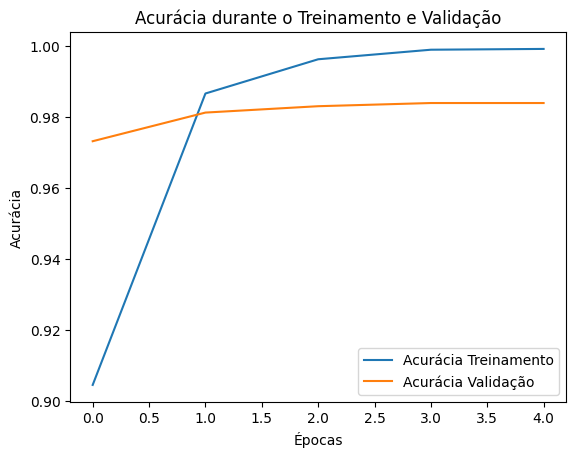

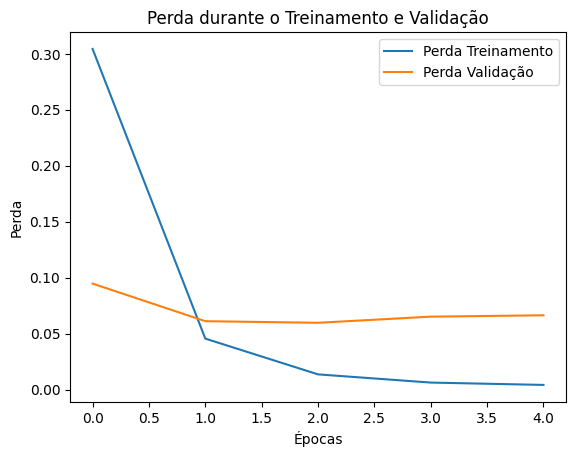

In [23]:
import matplotlib.pyplot as plt

# Plotar a acurácia
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Acurácia durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

# Plotar a perda
plt.plot(history.history['loss'], label='Perda Treinamento')
plt.plot(history.history['val_loss'], label='Perda Validação')
plt.title('Perda durante o Treinamento e Validação')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()